In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import time

import gym
import retro

import torch

import gym.envs.classic_control as control
from gym.wrappers import GrayScaleObservation

from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.vec_env import VecFrameStack, DummyVecEnv
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.atari_wrappers import MaxAndSkipEnv

2023-04-10 17:27:37.593346: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
torch.cuda.is_available()

True

In [4]:
class Discretizer(gym.ActionWrapper):

    def __init__(self, env, combos):
        super().__init__(env)
        assert isinstance(env.action_space, gym.spaces.MultiBinary)
        buttons = env.unwrapped.buttons
        self._decode_discrete_action = []
        for combo in combos:
            arr = np.array([False] * env.action_space.n)
            for button in combo:
                arr[buttons.index(button)] = True
            self._decode_discrete_action.append(arr)

        self.action_space = gym.spaces.Discrete(len(self._decode_discrete_action))

    def action(self, act):
        return self._decode_discrete_action[act].copy()


class MaRLioDiscretizer(Discretizer):

    def __init__(self, env):
        super().__init__(env=env, 
                         combos=[
            [],
            ["RIGHT"],
            ["RIGHT","Y"],
            ["RIGHT","A"],
            ["RIGHT","Y","A"],
            ["RIGHT","Y","B"],
            ["LEFT"],
            ["LEFT","Y"],
            ["LEFT","A"],
            ["LEFT","Y","A"],
            ["LEFT","Y","B"],
            ["A"],
            ["B"]
            ]
        )

In [5]:
# for train

env = retro.make(game="SuperMarioWorld-Snes", state="YoshiIsland3", record="./recordings/train/")

In [ ]:
# for pred

env = retro.make(game="SuperMarioWorld-Snes", state="YoshiIsland3", record="./recordings/pred/")

In [ ]:
# for test

env = retro.make(game="SuperMarioWorld-Snes", state="YoshiIsland3")

In [6]:
combos = [
    [],
    ["RIGHT"],
    ["RIGHT","Y"],
    ["RIGHT","A"],
    ["RIGHT","Y","A"],
    ["RIGHT","Y","B"],
    ["LEFT"],
    ["LEFT","Y"],
    ["LEFT","A"],
    ["LEFT","Y","A"],
    ["LEFT","Y","B"],
    ["A"],
    ["B"]
    ]

In [7]:
disc_env = MaRLioDiscretizer(env)

In [ ]:
obs = disc_env.reset()

In [ ]:
action = disc_env.action_space.sample()
print(action)
combos[action]

In [ ]:
obs, reward, terminated, info = disc_env.step(action)
print(f"score: {reward}\nterminated: {terminated}\ninfo: {info}")

In [ ]:
plt.matshow(obs)

In [ ]:
# game loop with random actions
state = disc_env.reset()

done = False
while not done:
    action = disc_env.action_space.sample()
    state, reward, done, info = disc_env.step(action)
    disc_env.render()
    time.sleep(0.005)
disc_env.render(close=True)

In [8]:
# preprocess: grayscale, vectorize and framestacking
disc_env = GrayScaleObservation(disc_env, keep_dim=True)
disc_env = DummyVecEnv([lambda:disc_env])
disc_env = VecFrameStack(disc_env, 4, channels_order="last")
# disc_env = MaxAndSkipEnv(disc_env, 4)

In [9]:
state = disc_env.reset()

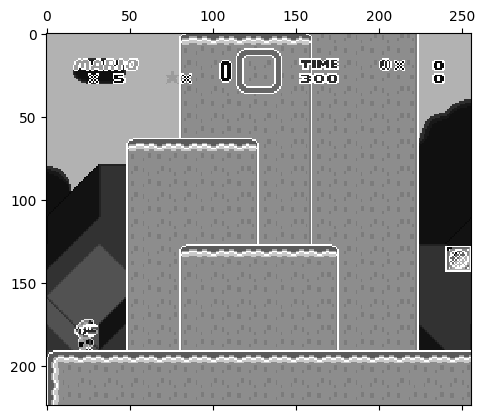

In [10]:
plt.matshow(state[0])

In [11]:
state.shape

(1, 224, 256, 4)

In [12]:
state, reward, done, info = disc_env.step([disc_env.action_space.sample()])

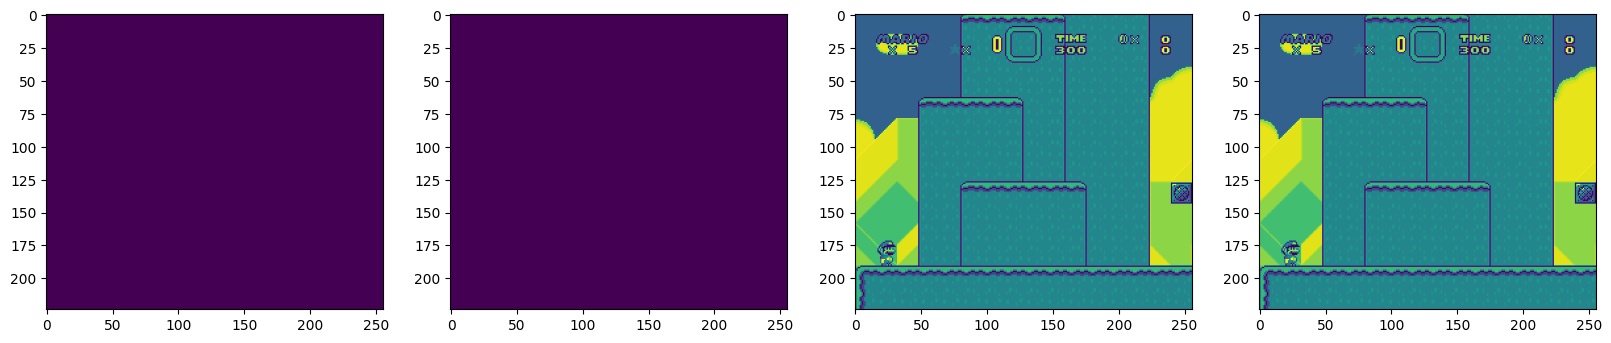

In [13]:
plt.figure(figsize=(20,16))
for idx in range(state.shape[3]):
    plt.subplot(1,4,idx+1)
    plt.imshow(state[0][:,:,idx])
plt.show()

In [14]:
state = disc_env.reset()

In [15]:
# callback helper function

# logs and model saving
class TrainAndLoggingCallback(BaseCallback):

    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, "best_model_{}".format(self.n_calls))
            self.model.save(model_path)

        return True

In [16]:
CHECKPOINT_DIR = "./train/"
LOG_DIR = "./logs/"

In [17]:
callback = TrainAndLoggingCallback(check_freq=10_000, save_path=CHECKPOINT_DIR)

In [18]:
# lambda params

lr = lambda f:f*0.0003
clipr = lambda f:f*0.2

In [19]:
model = PPO(
    "CnnPolicy", 
    disc_env, 
    learning_rate=lr, 
    n_steps=256, 
    batch_size=64, 
    n_epochs=10, 
    gamma=0.99, 
    gae_lambda=0.95, 
    clip_range=clipr, 
    clip_range_vf=None, 
    normalize_advantage=True, 
    ent_coef=0.01, 
    vf_coef=0.5, 
    max_grad_norm=0.5, 
    use_sde=False, 
    sde_sample_freq=-1, 
    target_kl=None,  
    tensorboard_log=LOG_DIR, 
    policy_kwargs=None, 
    verbose=0, 
    seed=42, 
    device='auto', 
    _init_setup_model=True
    )

In [ ]:
model.learn(
    total_timesteps=100_000, 
    progress_bar=True, 
    tb_log_name="ppo",
    callback=[
    callback
    ]
)

In [29]:
marlio = "best_model_100000.zip"
model = PPO.load(f"./train/{marlio}")
print(f"using {marlio}")

using best_model_100000.zip


In [30]:
state = disc_env.reset()

In [ ]:
# game loop for predict

done = False

action_list = [0]
while not done:

    action, _ = model.predict(state)
    if action[0] not in action_list:
        action_list.pop()
        action_list.append(action[0])
        print(combos[action_list[0]])
    state, reward, done, info = disc_env.step(action)

    disc_env.render()
    time.sleep(0.004)

In [32]:
env.data.list_variables()

{'score': {'address': 8261428, 'type': '<u4'},
 'lives': {'address': 8261054, 'type': '|i1'},
 'coins': {'address': 8261055, 'type': '|u1'}}

In [ ]:
%load_ext tensorboard

In [ ]:
# below code not used for now

In [ ]:
# possible playback code below

movie = retro.Movie("./recordings/train/SuperMarioWorld-Snes-YoshiIsland3-000008.bk2")
movie.step()

In [ ]:
env = retro.make(
    game=movie.get_game(),
    state=None,
    # bk2s can contain any button presses, so allow everything
    use_restricted_actions=retro.Actions.ALL,
    players=movie.players,
)
env.initial_state = movie.get_state()
env.reset()

In [ ]:
while movie.step():
    keys = []
    for p in range(movie.players):
        for i in range(env.num_buttons):
            keys.append(movie.get_key(i, p))
    env.step(keys)
    env.render()
    # time.sleep(0.004)

In [ ]:
def record_video(env, policy, out_directory, fps=30):
    images = []
    done = False
    state = env.reset()
    img = env.render(mode="rgb_array")
    images.append(img)
    while not done:
        state = torch.Tensor(state).to(device)
        # Take the action (index) that have the maximum expected future reward given that state
        action, _, _, _ = policy.get_action_and_value(state)
        state, reward, done, info = env.step(
            action.cpu().numpy()
        )  # We directly put next_state = state for recording logic
        img = env.render(mode="rgb_array")
        images.append(img)
    imageio.mimsave(out_directory, [np.array(img) for i, img in enumerate(images)], fps=fps)